In [1]:
import pandas as pd
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import DataLoader, Dataset


In [2]:
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")

# Custom dataset class
class CodeDataset():
    def __init__(self, texts, labels):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=256)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

In [3]:
# Load data
train_df = pd.read_csv(f"drive/MyDrive/Defector-codebert/train/allFeature.csv")
val_df = pd.read_csv(f"drive/MyDrive/Defector-codebert/val/allFeature.csv")
test_df = pd.read_csv(f"drive/MyDrive/Defector-codebert/test/allFeature.csv")

In [4]:
test_dataset = CodeDataset(test_df.iloc[:, 0].astype(str).tolist(), test_df.iloc[:, 1].tolist())

In [5]:
train_dataset = CodeDataset(train_df.iloc[:, 0].astype(str).tolist(), train_df.iloc[:, 1].tolist())


In [6]:
val_dataset = CodeDataset(val_df.iloc[:, 0].astype(str).tolist(), val_df.iloc[:, 1].tolist())

In [13]:
from transformers import EarlyStoppingCallback
# Load model
model = RobertaForSequenceClassification.from_pretrained("microsoft/codebert-base", num_labels=2)

training_args = TrainingArguments(
        output_dir=f"drive/MyDrive/Defector-codebert/results_all",
        eval_strategy="steps",
        eval_steps=3000,
        save_strategy="steps",
        save_steps=3000,
        save_total_limit=2,
        num_train_epochs=4,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        warmup_ratio=0.1,
        learning_rate=1e-5,
        weight_decay=0.01,
        logging_dir="./logs_all",
        logging_steps=500,
        load_best_model_at_end=True,
        metric_for_best_model='eval_loss',
        greater_is_better=True,
        fp16=True,
        report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
trainer.train()
model_to_save = trainer.model.module if hasattr(trainer.model, 'module') else trainer.model  # Take care of distributed/parallel training
model_to_save.save_pretrained('drive/MyDrive/Defector-codebert/trained_model')

Step,Training Loss,Validation Loss
3000,0.152700,0.084679
6000,0.122700,0.067035
9000,0.120700,0.065180
12000,0.115400,0.051769
15000,0.101200,0.053015
18000,0.098400,0.050114
21000,0.093400,0.059124
24000,0.087500,0.054920
27000,0.086400,0.055398
30000,0.091600,0.049650


In [15]:
predictions_train = trainer.predict(train_dataset)
predictions_val = trainer.predict(val_dataset)
predictions_test = trainer.predict(test_dataset)

print(len(predictions_train.predictions.argmax(-1)))

276508


In [16]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, classification_report
import json

predstest = predictions_test.predictions.argmax(-1)

predstrain = predictions_train.predictions.argmax(-1)

predsval = predictions_val.predictions.argmax(-1)

report_test = classification_report(predictions_test.label_ids, predstest, output_dict=True)
report_train = classification_report(predictions_train.label_ids, predstrain, output_dict=True)
report_val = classification_report(predictions_val.label_ids, predsval, output_dict=True)
print("Validation Report:")
print(report_test)
with open('drive/MyDrive/Defector-codebert/report_test.json', 'w') as f:
    json.dump(report_test, f, indent=4)
with open('drive/MyDrive/Defector-codebert/report_train.json', 'w') as f:
    json.dump(report_train, f, indent=4)
with open('drive/MyDrive/Defector-codebert/report_val.json', 'w') as f:
    json.dump(report_val, f, indent=4)

print("Validation report saved to 'validation_report.json'")

Validation Report:
{'0': {'precision': 0.9886167293424128, 'recall': 0.9858112901591163, 'f1-score': 0.9872120166446767, 'support': 9867.0}, '1': {'precision': 0.889937106918239, 'recall': 0.909967845659164, 'f1-score': 0.8998410174880763, 'support': 1244.0}, 'accuracy': 0.977319773197732, 'macro avg': {'precision': 0.939276918130326, 'recall': 0.9478895679091401, 'f1-score': 0.9435265170663765, 'support': 11111.0}, 'weighted avg': {'precision': 0.9775684483329923, 'recall': 0.977319773197732, 'f1-score': 0.977429861757555, 'support': 11111.0}}
Validation report saved to 'validation_report.json'


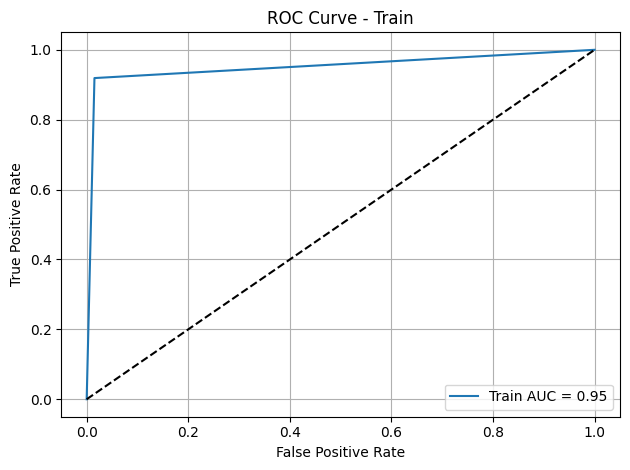

In [21]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import json
import os

# Dummy example: y_true and y_scores for each split
results = {}

# Replace these with your actual true labels and predicted probabilities
splits = ['Train']
for split in splits:
    y_true = predictions_train.label_ids  # true binary labels for split
    y_score =predstrain # predicted probabilities for split

    # AUC Score
    aoc = roc_auc_score(y_true, y_score)
    results[split] = {"auc": aoc}

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_score)

    # Plot and save ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'{split} AUC = {aoc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Train')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig(f'drive/MyDrive/Defector-codebert/roc_curve_{split}.png')
    # plt.close()

# Save AUC scores to a JSON file
with open(f'drive/MyDrive/Defector-codebert/roc_scores_{split}.json', 'w') as f:
    json.dump(results, f, indent=4)